In [1]:
import os
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D

from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


In [3]:
import pandas as pd
train_folder = '/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df


        

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [4]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

In [5]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [6]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(29, activation = "softmax"))

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
# model.summary()

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=128
epochs=5

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/5
230/230 [==============================] - 630s 3s/step - loss: 2.2393 - accuracy: 0.3318 - val_loss: 0.7500 - val_accuracy: 0.7537
Epoch 2/5
230/230 [==============================] - 118s 513ms/step - loss: 0.4887 - accuracy: 0.8325 - val_loss: 0.2107 - val_accuracy: 0.9344
Epoch 3/5
230/230 [==============================] - 122s 529ms/step - loss: 0.2053 - accuracy: 0.9291 - val_loss: 0.0832 - val_accuracy: 0.9747
Epoch 4/5
230/230 [==============================] - 123s 534ms/step - loss: 0.1249 - accuracy: 0.9560 - val_loss: 0.0553 - val_accuracy: 0.9822
Epoch 5/5
230/230 [==============================] - 119s 519ms/step - loss: 0.0982 - accuracy: 0.9665 - val_loss: 0.0392 - val_accuracy: 0.9864


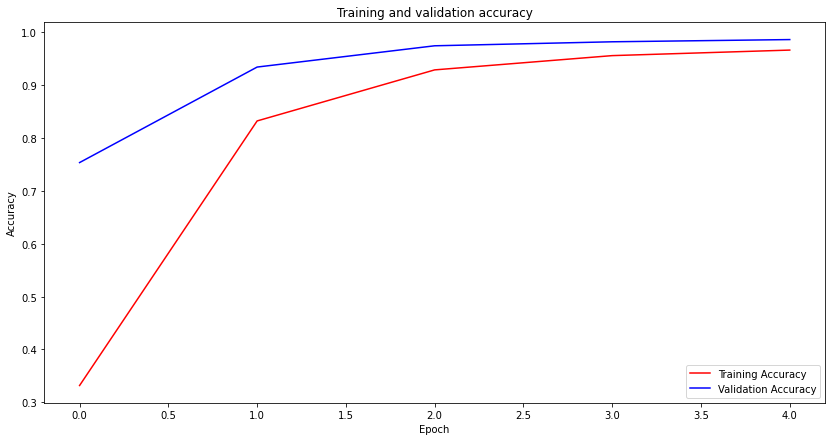

In [9]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

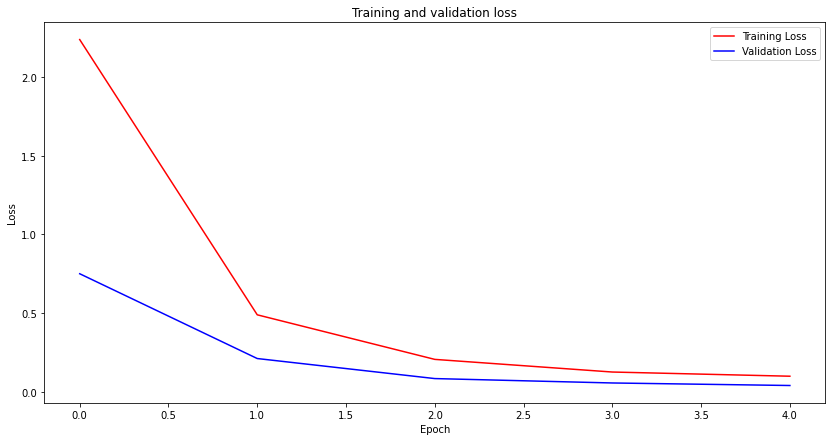

In [10]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

# Prediction<span id="7"></span>

#### Finally predicting and checking the accuracy from the holdout data.

In [11]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

34/34 [==============================] - 75s 2s/step
              precision    recall  f1-score   support

           A       0.97      1.00      0.99       300
           B       0.97      1.00      0.99       300
           C       1.00      0.99      0.99       300
           D       1.00      1.00      1.00       300
           E       1.00      0.96      0.98       300
           F       1.00      1.00      1.00       300
           G       1.00      0.99      1.00       300
           H       0.99      1.00      1.00       300
           I       1.00      1.00      1.00       300
           J       1.00      1.00      1.00       300
           K       0.96      0.99      0.98       300
           L       1.00      1.00      1.00       300
           M       0.99      1.00      0.99       300
           N       0.99      0.99      0.99       300
           O       1.00      0.99      0.99       300
           P       1.00      0.99      0.99       300
           Q       0.99     

In [13]:
model.save('ASL_classification.h5')

In [22]:
class_labels

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']